In [1]:
import os
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import jax
import cv2
import tensorflow_datasets as tfds
import tqdm
import mediapy
import numpy as np

import tensorflow as tf

tf.config.set_visible_devices([], "GPU")

import jax.numpy as jnp
from absl import app, flags
import optax
import json
import numpy as np
from functools import partial
import orbax.checkpoint as ocp
from tensorflow_text import SentencepieceTokenizer
# from palivla.dataset import prepare_image
from palivla.tokenizer import Tokenizer
from palivla.load_model import load_model_params_decode
from scalax.sharding import MeshShardingHelper, FSDPShardingRule, PartitionSpec
from flax.training.train_state import TrainState
from jax.experimental import multihost_utils
from ml_collections import config_flags
from palivla.train_state import PaliVLATrainState
from palivla.types import TrainingBatch, RolloutBatch

# export TPU_VISIBLE_DEVICES=0 
# export TPU_CHIPS_PER_HOST_BOUNDS=1,1,1 
# export TPU_HOST_BOUNDS=1,1,1 
# export TPU_MESH_CONTROLLER_ADDRESS=localhost:8476 
# export TPU_MESH_CONTROLLER_PORT=8476

os.environ['TPU_VISIBLE_DEVICES'] = '0'
os.environ['TPU_CHIPS_PER_HOST_BOUNDS'] = '1,1,1'
os.environ['TPU_HOST_BOUNDS'] = '1,1,1'
os.environ['TPU_MESH_CONTROLLER_ADDRESS'] = 'localhost:8476'
os.environ['TPU_MESH_CONTROLLER_PORT'] = '8476'


/nfs/nfs2/users/mitsuhiko/miniconda/envs/big_vision/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-27 01:29:22.425308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732670962.444739  893902 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732670962.450667  893902 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 01:29:25.072741: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call 

## Load Datasets
Next, we will load a trajectory from the bridge dataset for testing the model. We will use the publicly available copy in the Open X-Embodiment dataset bucket.

In [2]:
# create RLDS dataset builder
builder = tfds.builder_from_directory(builder_dir='gs://gresearch/robotics/bridge/0.1.0/')
ind = np.random.randint(0, 1000)
ds = builder.as_dataset(split=f'train[{ind}:{ind+1}]')

# sample episode + resize to 256x256 (default third-person cam resolution)
episode = next(iter(ds))
steps = list(episode['steps'])
images = [cv2.resize(np.array(step['observation']['image']), (224, 224)) for step in steps]

# extract goal image & language instruction
goal_image = images[-1]
language_instruction = steps[0]['observation']['natural_language_instruction'].numpy().decode()

# visualize episode
print(f'Instruction: {language_instruction}')
mediapy.show_video(images, fps=10)

Instruction: take lid off pot cardboardfence


In [3]:


# action_mean = np.array(dataset_statistics[dataset_name]["action"]["mean"])
# action_std = np.array(dataset_statistics[dataset_name]["action"]["std"])
# action_mask = np.array(dataset_statistics[dataset_name]["action"]["mask"])
def make_inference_batch(batch):
    sensors = {
        k: batch["observation"][k][None].numpy()
        for k in batch["observation"]
        if k in model.model_state.model.modality_mappings and k != "text"
    }
    sensors_mask = {
        k: batch["observation"]["pad_mask_dict"][k].numpy()
        for k in model.model_state.model.modality_mappings
        if k != "text"
    }
    return RolloutBatch(
            sensor_data=sensors,
            sensor_masks=sensors_mask,
            prompt=batch["tokens"][None].numpy(),
            prompt_mask=batch["mask_input"][None].numpy(),
            prompt_ar=np.zeros_like(batch["mask_ar"][None]),
        )
    

# Do inference
def do_inference(images, instructions):
    data = {
        "observation": {"image_primary": images, "pad_mask_dict": {"image_primary": tf.ones(len(images), dtype=tf.bool)}},
        "task": {"language_instruction": instructions},
    }
    language_token_instructions = tokenizer.tokenize_language_instruction(data)
    # batch = prepare_image(batch)
    batch = tokenizer.prepare_tokens_for_generation(data, language_token_instructions)
    batch = batch | data
    rollout_batch = make_inference_batch(batch)

    out_tokens, value = decode(
        rollout_batch, None
    )
    out_tokens = jax.device_get(multihost_utils.process_allgather(out_tokens))
    value = jax.device_get(multihost_utils.process_allgather(value))
    decoded_actions = tokenizer.detokenize_action(out_tokens)

    # Re-normalize actions using dataset statistics
    # decoded_actions = decoded_actions * action_std + action_mean
    # decoded_actions = unnormalize_action(decoded_actions, dataset_statistics[dataset_name]["action"])
    decoded_actions = unnormalize_action_minmax(decoded_actions, dataset_statistics[dataset_name]["action"])

    return decoded_actions, value

def unnormalize_action(action, unnormalization_statistics):
    mask = unnormalization_statistics.get(
        "mask", jnp.ones_like(unnormalization_statistics["mean"], dtype=bool)
    )
    action = action[..., : len(mask)]
    action = jnp.where(
        mask,
        (action * unnormalization_statistics["std"])
        + unnormalization_statistics["mean"],
        action,
    )
    return action

def unnormalize_action_minmax(action, unnormalization_statistics):
    mask = unnormalization_statistics.get(
        "mask", jnp.ones_like(unnormalization_statistics["mean"], dtype=bool)
    )
    action = action[..., : len(mask)]
    action = jnp.where(
        mask,
        (action + 1) / 2 * (unnormalization_statistics["p99"] - unnormalization_statistics["p01"]) + unnormalization_statistics["p01"],
        action,
    )

    return action

In [10]:
resume_from_checkpoint_dir = "gs://rail-tpus-mitsuhiko-central2/logs/test/dandy-grass-21/"
# resume_from_checkpoint_step = "gs://rail-tpus-mitsuhiko-central2/logs/test/bright-thunder-2/"
resume_from_checkpoint_step = 20000
dataset_name = "bridge_dataset"

In [11]:
# Sharding
mesh = MeshShardingHelper([-1], ["fsdp"])

model_sharding = FSDPShardingRule("fsdp", fsdp_axis_size=mesh.mesh.shape["fsdp"])
data_sharding = PartitionSpec("fsdp")
# data_sharding = jax.sharding.SingleDeviceSharding(jax.local_devices()[0])

restore_checkpoint_manager = ocp.CheckpointManager(
        resume_from_checkpoint_dir,
        item_handlers=PaliVLATrainState.get_checkpoint_handlers(),
)

model = PaliVLATrainState.restore(
        checkpoint_manager=restore_checkpoint_manager,
        step=resume_from_checkpoint_step,
        load_optimizer=False,
        mesh=mesh,
        model_sharding=model_sharding,
        data_sharding=data_sharding,
    )
tokenizer = model.tokenizer
decode = model.decode
dataset_statistics = model.dataset_statistics


In [12]:
tokenizer

Tokenizer(config=Tokenizer.TokenizerConfig(action_vocab_size=256, action_vocab_offset=256000, vocab_size=<bound method SentencepieceTokenizer.vocab_size of <tensorflow_text.python.ops.sentencepiece_tokenizer.SentencepieceTokenizer object at 0x7f5f8e2293c0>>, num_action_tokens=7, bos_token=2, eos_token=1, pad_token=0, begin_of_action_token=108, end_of_action_token=3, max_pad_length=60, min_action_value=-2, max_action_value=2, prompt_autoregressive=False), language_tokenizer=<tensorflow_text.python.ops.sentencepiece_tokenizer.SentencepieceTokenizer object at 0x7f5f8e2293c0>, token_structure=FrozenDict({
    causal: ('action', (3,)),
    pad: ((0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),),
    prefix: ((2,), 'prompt', (108,)),
}), action_tokenizer=BinActionTokenizer(
    # attributes
    min_action_value = -2
    max_action_value = 2
    action_dim = 7
 

## Run Inference

Next, we will run inference over the images in the episode using the loaded model. 
Below we demonstrate setups for both, goal-conditioned and language-conditioned training.
Note that we need to feed inputs of the correct temporal window size.

In [13]:
WINDOW_SIZE = 1
# run inference loop, this model only uses single image observations for bridge
# collect predicted and true actions
pred_actions, true_actions = [], []
pred_values = []
for step in tqdm.trange(len(images) - (WINDOW_SIZE - 1)):
    input_image = images[step][None]
    input_image = tf.cast(input_image, tf.float32) / 127.5 - 1.0
    instruction = tf.constant(language_instruction)
    
    actions, value = do_inference(input_image, instruction)
    print(value, actions)
    pred_actions.append(actions)
    pred_values.append(value)

    true_actions.append(np.concatenate(
        (
            steps[step]['action']['world_vector'], 
            steps[step]['action']['rotation_delta'], 
            np.array(steps[step]['action']['open_gripper']).astype(np.float32)[None]
        ), axis=-1
    ))

  3%|▎         | 1/39 [00:00<00:08,  4.34it/s]

[[53305]]
-13.601501
[[53305]]
-13.279968
[[53305]]
-13.069153
[[53305]]
-13.17622
[[53305]]
-13.096052
[[53305]]
-13.189144
[[53305]]
-13.189144 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]


  5%|▌         | 2/39 [00:00<00:07,  5.00it/s]

[[53305]]
-13.602566
[[53305]]
-13.279734
[[53305]]
-13.064987
[[53305]]
-13.17544
[[53305]]
-13.095789
[[53305]]
-13.188015
[[53305]]
-13.188015 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.603338
[[53305]]


  8%|▊         | 3/39 [00:00<00:06,  5.26it/s]

-13.280289
[[53305]]
-13.068138
[[53305]]
-13.177942
[[53305]]
-13.099508
[[53305]]
-13.189728
[[53305]]
-13.189728 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.599342
[[53305]]
-13.2702265
[[53305]]
-13.064276


 10%|█         | 4/39 [00:00<00:06,  5.40it/s]

[[53305]]
-13.176743
[[53305]]
-13.099127
[[53305]]
-13.187397
[[53305]]
-13.187397 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.599693
[[53305]]
-13.267469
[[53305]]
-13.067636
[[53305]]
-13.172246
[[53305]]


 13%|█▎        | 5/39 [00:00<00:06,  5.48it/s]

-13.09882
[[53305]]
-13.19639
[[53305]]
-13.19639 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.617638
[[53305]]
-13.260607
[[53305]]
-13.063759
[[53305]]
-13.179123
[[53305]]
-13.102399
[[53305]]


 18%|█▊        | 7/39 [00:01<00:05,  5.55it/s]

-13.210694
[[53305]]
-13.210694 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.588337
[[53305]]
-13.2547
[[53305]]
-13.072754
[[53305]]
-13.174909
[[53305]]
-13.112267
[[53305]]
-13.198704
[[53305]]
-13.198704 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]


 21%|██        | 8/39 [00:01<00:05,  5.57it/s]

[[53305]]
-13.594265
[[53305]]
-13.248997
[[53305]]
-13.07757
[[53305]]
-13.179847
[[53305]]
-13.107378
[[53305]]
-13.194452
[[53305]]
-13.194452 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.586136


 23%|██▎       | 9/39 [00:01<00:05,  5.58it/s]

[[53305]]
-13.217923
[[53305]]
-13.068417
[[53305]]
-13.149708
[[53305]]
-13.104086
[[53305]]
-13.20326
[[53305]]
-13.20326 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.597155
[[53305]]
-13.216385
[[53305]]


 26%|██▌       | 10/39 [00:01<00:05,  5.59it/s]

-13.044982
[[53305]]
-13.161909
[[53305]]
-13.107809
[[53305]]
-13.213993
[[53305]]
-13.213993 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.602306
[[53305]]
-13.239493
[[53305]]
-13.045094
[[53305]]
-13.1710005
[[53305]]


 28%|██▊       | 11/39 [00:02<00:04,  5.61it/s]

-13.113762
[[53305]]
-13.197474
[[53305]]
-13.197474 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.603524
[[53305]]
-13.245808
[[53305]]
-13.048596
[[53305]]
-13.157851
[[53305]]
-13.118107
[[53305]]
-13.204622


 33%|███▎      | 13/39 [00:02<00:04,  5.60it/s]

[[53305]]
-13.204622 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.597593
[[53305]]
-13.236837
[[53305]]
-13.046703
[[53305]]
-13.159552
[[53305]]
-13.112881
[[53305]]
-13.207928
[[53305]]
-13.207928 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]


 36%|███▌      | 14/39 [00:02<00:04,  5.60it/s]

[[53305]]
-13.598259
[[53305]]
-13.233122
[[53305]]
-13.047228
[[53305]]
-13.167875
[[53305]]
-13.099419
[[53305]]
-13.204197
[[53305]]
-13.204197 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.595083


 38%|███▊      | 15/39 [00:02<00:04,  5.60it/s]

[[53305]]
-13.218834
[[53305]]
-13.040342
[[53305]]
-13.166117
[[53305]]
-13.092194
[[53305]]
-13.218351
[[53305]]
-13.218351 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.605732
[[53305]]
-13.230253


 41%|████      | 16/39 [00:02<00:04,  5.60it/s]

[[53305]]
-13.043884
[[53305]]
-13.175116
[[53305]]
-13.104853
[[53305]]
-13.216949
[[53305]]
-13.216949 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.608866
[[53305]]
-13.237644
[[53305]]
-13.041472
[[53305]]


 44%|████▎     | 17/39 [00:03<00:03,  5.60it/s]

-13.177864
[[53305]]
-13.105484
[[53305]]
-13.216709
[[53305]]
-13.216709 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.601892
[[53305]]
-13.240575
[[53305]]
-13.037382
[[53305]]
-13.161203
[[53305]]


 46%|████▌     | 18/39 [00:03<00:03,  5.59it/s]

-13.105577
[[53305]]
-13.223064
[[53305]]
-13.223064 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.606348
[[53305]]
-13.241451
[[53305]]
-13.043346
[[53305]]
-13.174127
[[53305]]
-13.102576
[[53305]]


 51%|█████▏    | 20/39 [00:03<00:03,  5.59it/s]

-13.229679
[[53305]]
-13.229679 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.59943
[[53305]]
-13.236267
[[53305]]
-13.040897
[[53305]]
-13.164612
[[53305]]
-13.099878
[[53305]]
-13.234951
[[53305]]
-13.234951 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]


 54%|█████▍    | 21/39 [00:03<00:03,  5.58it/s]

[[53305]]
-13.588848
[[53305]]
-13.22555
[[53305]]
-13.059616
[[53305]]
-13.163808
[[53305]]
-13.102799
[[53305]]
-13.237629
[[53305]]
-13.237629 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]


 56%|█████▋    | 22/39 [00:03<00:03,  5.57it/s]

-13.591649
[[53305]]
-13.228262
[[53305]]
-13.066372
[[53305]]
-13.169678
[[53305]]
-13.112307
[[53305]]
-13.248197
[[53305]]
-13.248197 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.589069
[[53305]]
-13.240507


 59%|█████▉    | 23/39 [00:04<00:02,  5.57it/s]

[[53305]]
-13.068434
[[53305]]
-13.170534
[[53305]]
-13.121298
[[53305]]
-13.26552
[[53305]]
-13.26552 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.589411
[[53305]]
-13.246981
[[53305]]


 62%|██████▏   | 24/39 [00:04<00:02,  5.58it/s]

-13.062511
[[53305]]
-13.164421
[[53305]]
-13.120574
[[53305]]
-13.253698
[[53305]]
-13.253698 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.607927
[[53305]]
-13.260356
[[53305]]
-13.06183
[[53305]]
-13.180307
[[53305]]


 64%|██████▍   | 25/39 [00:04<00:02,  5.61it/s]

-13.115006
[[53305]]
-13.227017
[[53305]]
-13.227017 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.604919
[[53305]]
-13.260528
[[53305]]
-13.058537
[[53305]]
-13.176743
[[53305]]
-13.108469
[[53305]]
-13.202661


 69%|██████▉   | 27/39 [00:04<00:02,  5.61it/s]

[[53305]]
-13.202661 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.60858
[[53305]]
-13.264059
[[53305]]
-13.0602665
[[53305]]
-13.178793
[[53305]]
-13.104948
[[53305]]
-13.202247
[[53305]]
-13.202247 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]


 72%|███████▏  | 28/39 [00:05<00:01,  5.62it/s]

[[53305]]
-13.605015
[[53305]]
-13.261799
[[53305]]
-13.057577
[[53305]]
-13.183544
[[53305]]
-13.102126
[[53305]]
-13.199945
[[53305]]
-13.199945 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.603956
[[53305]]


 74%|███████▍  | 29/39 [00:05<00:01,  5.64it/s]

-13.263136
[[53305]]
-13.055069
[[53305]]
-13.181629
[[53305]]
-13.100588
[[53305]]
-13.197675
[[53305]]
-13.197675 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.607748
[[53305]]
-13.262428
[[53305]]
-13.053156
[[53305]]


 77%|███████▋  | 30/39 [00:05<00:01,  5.65it/s]

-13.181568
[[53305]]
-13.1012535
[[53305]]
-13.198698
[[53305]]
-13.198698 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.607712
[[53305]]
-13.262209
[[53305]]
-13.053874
[[53305]]
-13.18159
[[53305]]
-13.10211


 79%|███████▉  | 31/39 [00:05<00:01,  5.64it/s]

[[53305]]
-13.197292
[[53305]]
-13.197292 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.606586
[[53305]]
-13.259266
[[53305]]
-13.053267
[[53305]]
-13.179163
[[53305]]
-13.10326
[[53305]]
-13.19475
[[53305]]


 85%|████████▍ | 33/39 [00:05<00:01,  5.64it/s]

-13.19475 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.597048
[[53305]]
-13.24984
[[53305]]
-13.053616
[[53305]]
-13.170336
[[53305]]
-13.104635
[[53305]]
-13.200301
[[53305]]
-13.200301 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]


 87%|████████▋ | 34/39 [00:06<00:00,  5.63it/s]

[[53305]]
-13.604094
[[53305]]
-13.258419
[[53305]]
-13.05534
[[53305]]
-13.176671
[[53305]]
-13.104343
[[53305]]
-13.213226
[[53305]]
-13.213226 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.603232


 90%|████████▉ | 35/39 [00:06<00:00,  5.62it/s]

[[53305]]
-13.2589655
[[53305]]
-13.054371
[[53305]]
-13.170306
[[53305]]
-13.104919
[[53305]]
-13.211164
[[53305]]
-13.211164 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.602921
[[53305]]
-13.256264


 92%|█████████▏| 36/39 [00:06<00:00,  5.61it/s]

[[53305]]
-13.05221
[[53305]]
-13.176274
[[53305]]
-13.103965
[[53305]]
-13.208473
[[53305]]
-13.208473 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.605961
[[53305]]
-13.257635
[[53305]]
-13.058861


 95%|█████████▍| 37/39 [00:06<00:00,  5.61it/s]

[[53305]]
-13.179819
[[53305]]
-13.104269
[[53305]]
-13.199988
[[53305]]
-13.199988 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.607031
[[53305]]
-13.251186
[[53305]]
-13.055662
[[53305]]
-13.178436
[[53305]]


 97%|█████████▋| 38/39 [00:06<00:00,  5.62it/s]

-13.105017
[[53305]]
-13.20417
[[53305]]
-13.20417 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]
[[53305]]
-13.608637
[[53305]]
-13.250991
[[53305]]
-13.057436
[[53305]]
-13.182436
[[53305]]
-13.108614
[[53305]]
-13.211011
[[53305]]


100%|██████████| 39/39 [00:07<00:00,  5.57it/s]

-13.211011 [[[  -89.78398  -130.0327   -104.4568   -255.79103  -268.39044
    -645.90845 -3169.1094 ]]]


In [14]:
np.array(pred_actions).shape

(39, 1, 1, 7)

## Visualize predictions and ground-truth actions

Finally, we will visualize the predicted actions in comparison to the groundtruth actions.

/tmp/ipykernel_893902/1693310813.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


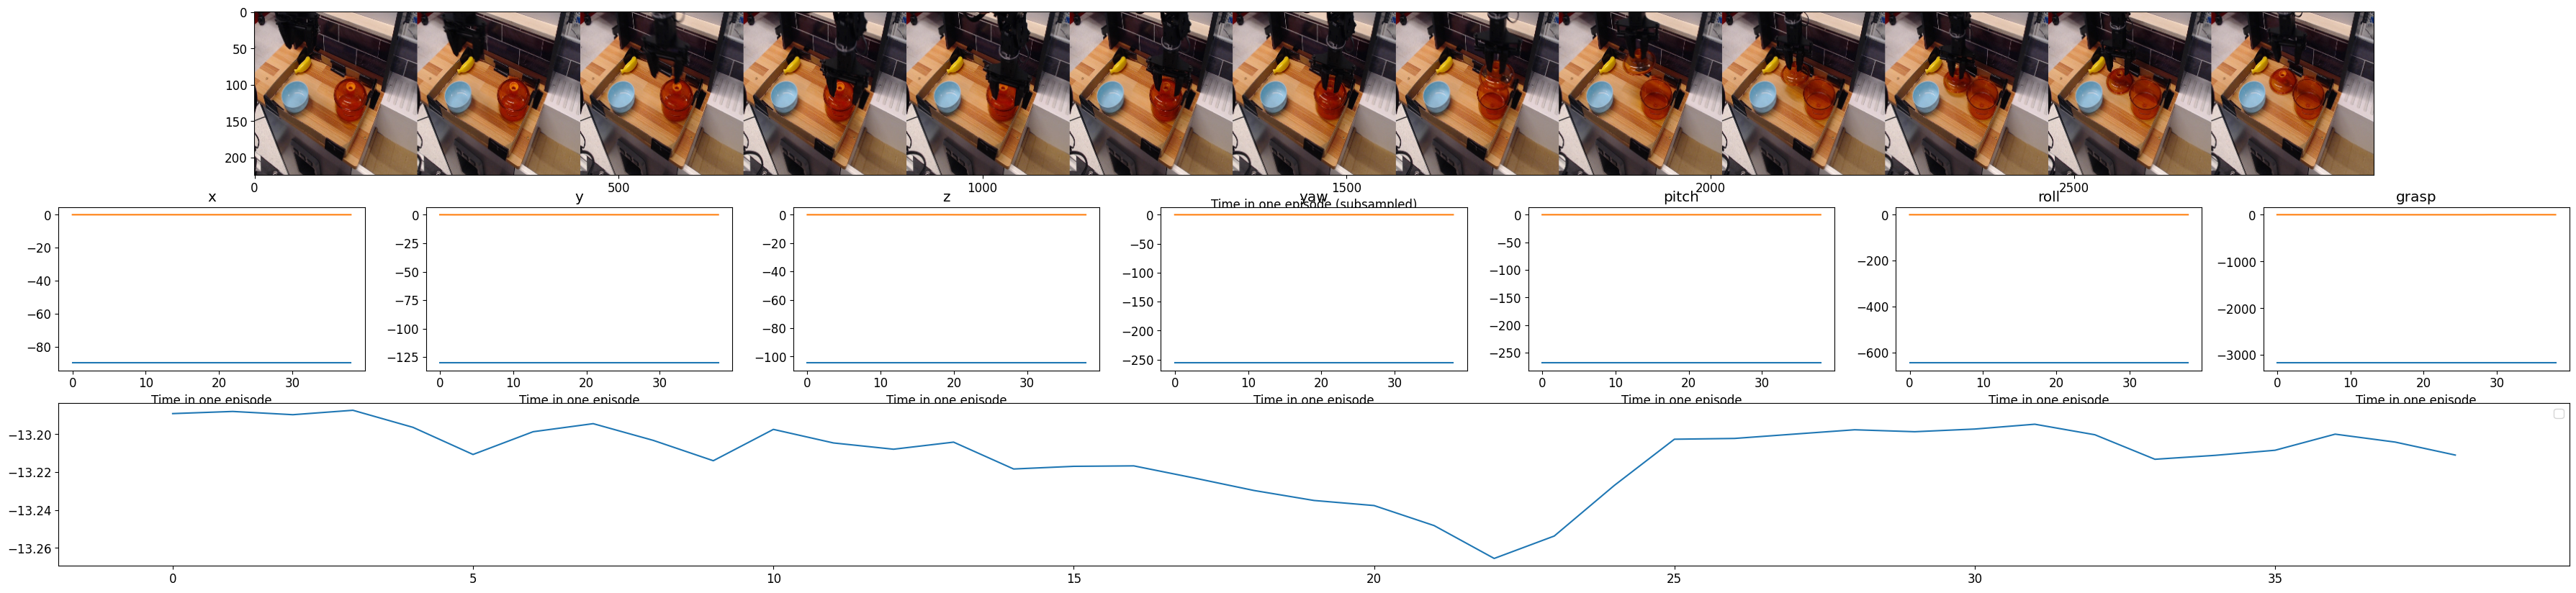

In [15]:
import matplotlib.pyplot as plt

ACTION_DIM_LABELS = ['x', 'y', 'z', 'yaw', 'pitch', 'roll', 'grasp']

# build image strip to show above actions
img_strip = np.concatenate(np.array(images[::3]), axis=1)

# set up plt figure
figure_layout = [
    ['image'] * len(ACTION_DIM_LABELS),
    ACTION_DIM_LABELS,
    ["value"] * len(ACTION_DIM_LABELS),
]
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplot_mosaic(figure_layout)
fig.set_size_inches([45, 10])

# plot actions
pred_actions = np.array(pred_actions).squeeze()
true_actions = np.array(true_actions).squeeze()
for action_dim, action_label in enumerate(ACTION_DIM_LABELS):
  # actions have batch, horizon, dim, in this example we just take the first action for simplicity
  axs[action_label].plot(pred_actions[:, action_dim], label='predicted action')
  axs[action_label].plot(true_actions[:, action_dim], label='ground truth')
  axs[action_label].set_title(action_label)
  axs[action_label].set_xlabel('Time in one episode')

# plot value
axs['value'].plot(pred_values)

axs['image'].imshow(img_strip)
axs['image'].set_xlabel('Time in one episode (subsampled)')
plt.legend()